# Predicting Academic Performance And Identifying The Primary Contributing Factors In Secondary Education

The purpose of this project is twofold:

* To use machine learning methods with collected data to reasonably predict the academic performance of secondary education students. 
* To help determine what factors in a student’s life influence, both positively and negatively, academic performance. 

Communities and educators can use this information to better understand how to manage their limited education resources in order to improve the quality of education provided to their students. 

As well, at-risk students can be identified early on allowing corrective measures to be taken to improve the student's academic performance.

In [1]:
# Imports, settings, and variables.

# Data analysis and visualisation.
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display, Markdown

# Scikit-learn classifiers.
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Scikit-learn processing modules.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
# from sklearn.model_selection import GridSearchCV

# Scikit-learn evaluation modules.
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score

# Interactive widgets.
from ipywidgets import Output, Layout, Button, Box, HBox, VBox

# Global settings.
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style="darkgrid")

# Global variables.
passing_score = 1
feature_threshold = 0.015
random_seed = 42
test_fraction = 0.2
num_trials = 5
cv_splits = 5
palette='mako'
cmap='mako_r'
color='#479c9e'

## Exploring The Data

This project uses publicly available data hosted on the University of California, Irvine website within their Machine Learning Repository entitled '*Student Performance Data Set*'. 

https://archive.ics.uci.edu/ml/datasets/Student+Performance. 

The data was taken from two Portuguese secondary education schools from the year 2007 and consists of 1043 individual student records covering the subjects of mathematics and the Portuguese language. The data was collected using school reports and student questionnaires. No student names or other personally identifiable information is included
in the data.

In [2]:
# Import and combine student data from both mathematics and Portugese data sets.
math_df = pd.read_csv('Data/student-mat.csv', sep = ';')
port_df = pd.read_csv('Data/student-por.csv', sep = ';')
df = pd.concat([math_df, port_df], ignore_index=True)
students = df.copy()

feature_desc = {'school': 'School', 
                'sex': 'Gender', 
                'age': 'Age', 
                'address': 'Address Zone', 
                'famsize': 'Family Size', 
                'Pstatus': 'Parents Cohabitation', 
                'Medu': 'Mother Education', 
                'Fedu': 'Father Education', 
                'Mjob': 'Mother Job', 
                'Fjob': 'Father Job', 
                'reason': 'Reason School Chosen', 
                'guardian': 'Guardian', 
                'traveltime': 'Travel Time', 
                'studytime': 'Study Time', 
                'health': 'Health Status', 
                'failures': 'Past Failures', 
                'schoolsup': 'Extra Educational Support', 
                'famsup': 'Family Educational Support', 
                'paid': 'Paid Classes', 
                'activities': 'Extra-Curricular Activities', 
                'nursery': 'Nursery School',
                'higher': 'Intends Higher Education', 
                'internet': 'Home Internet', 
                'romantic': 'Romantic Relationship', 
                'famrel': 'Family Relationships', 
                'freetime': 'Free Time', 
                'goout': 'Going Out With Friends', 
                'Dalc': 'Workday Alcohol', 
                'Walc': 'Weekend Alcohol', 
                'absences': 'Absences', 
                'G1': 'First Period Grade', 
                'G2': 'Second Period Grade', 
                'G3': 'Final Grade'}

In [3]:
# Display student data features.
display(students.head())

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


### Feature Description

* **school** - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
* **sex** - student's sex (binary: 'F' - female or 'M' - male)
* **age** - student's age (numeric: from 15 to 22)
* **address** - student's home address type (binary: 'U' - urban or 'R' - rural)
* **famsize** - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
* **Pstatus** - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
* **Medu** - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - “ 5th to 9th grade, 3 - “ secondary education or 4 - “ higher education)
* **Fedu** - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - “ 5th to 9th grade, 3 - “ secondary education or 4 - “ higher education)
* **Mjob** - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
* **Fjob** - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
* **reason** - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
* **guardian** - student's guardian (nominal: 'mother', 'father' or 'other')
* **traveltime** - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
* **studytime** - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
* **failures** - number of past class failures (numeric: n if 1<=n<3, else 4)
* **schoolsup** - extra educational support (binary: yes or no)
* **famsup** - family educational support (binary: yes or no)
* **paid** - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
* **activities** - extra-curricular activities (binary: yes or no)
* **nursery** - attended nursery school (binary: yes or no)
* **higher** - wants to take higher education (binary: yes or no)
* **internet** - Internet access at home (binary: yes or no)
* **romantic** - with a romantic relationship (binary: yes or no)
* **famrel** - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
* **freetime** - free time after school (numeric: from 1 - very low to 5 - very high)
* **goout** - going out with friends (numeric: from 1 - very low to 5 - very high)
* **Dalc** - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
* **Walc** - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
* **health** - current health status (numeric: from 1 - very bad to 5 - very good)
* **absences** - number of school absences (numeric: from 0 to 93)

Grades are related to the course subjects Math and Portuguese:
* **G1** - first period grade (numeric: from 0 to 20)
* **G2** - second period grade (numeric: from 0 to 20)
* **G3** - final grade (numeric: from 0 to 20, output target), changed to standard letter grade (ordinal: from 4(A) to 0(E))
  * A : 18 - 20
  * B : 16 - 17
  * C : 14 - 15
  * D : 12 - 13
  * E : 0 - 11

In [4]:
# Display statistical analysis of student data.
display(Markdown("### Statistical Distribution"))
print()
display(students.describe())

### Statistical Distribution

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


### Compare Feature Catagory Distribution

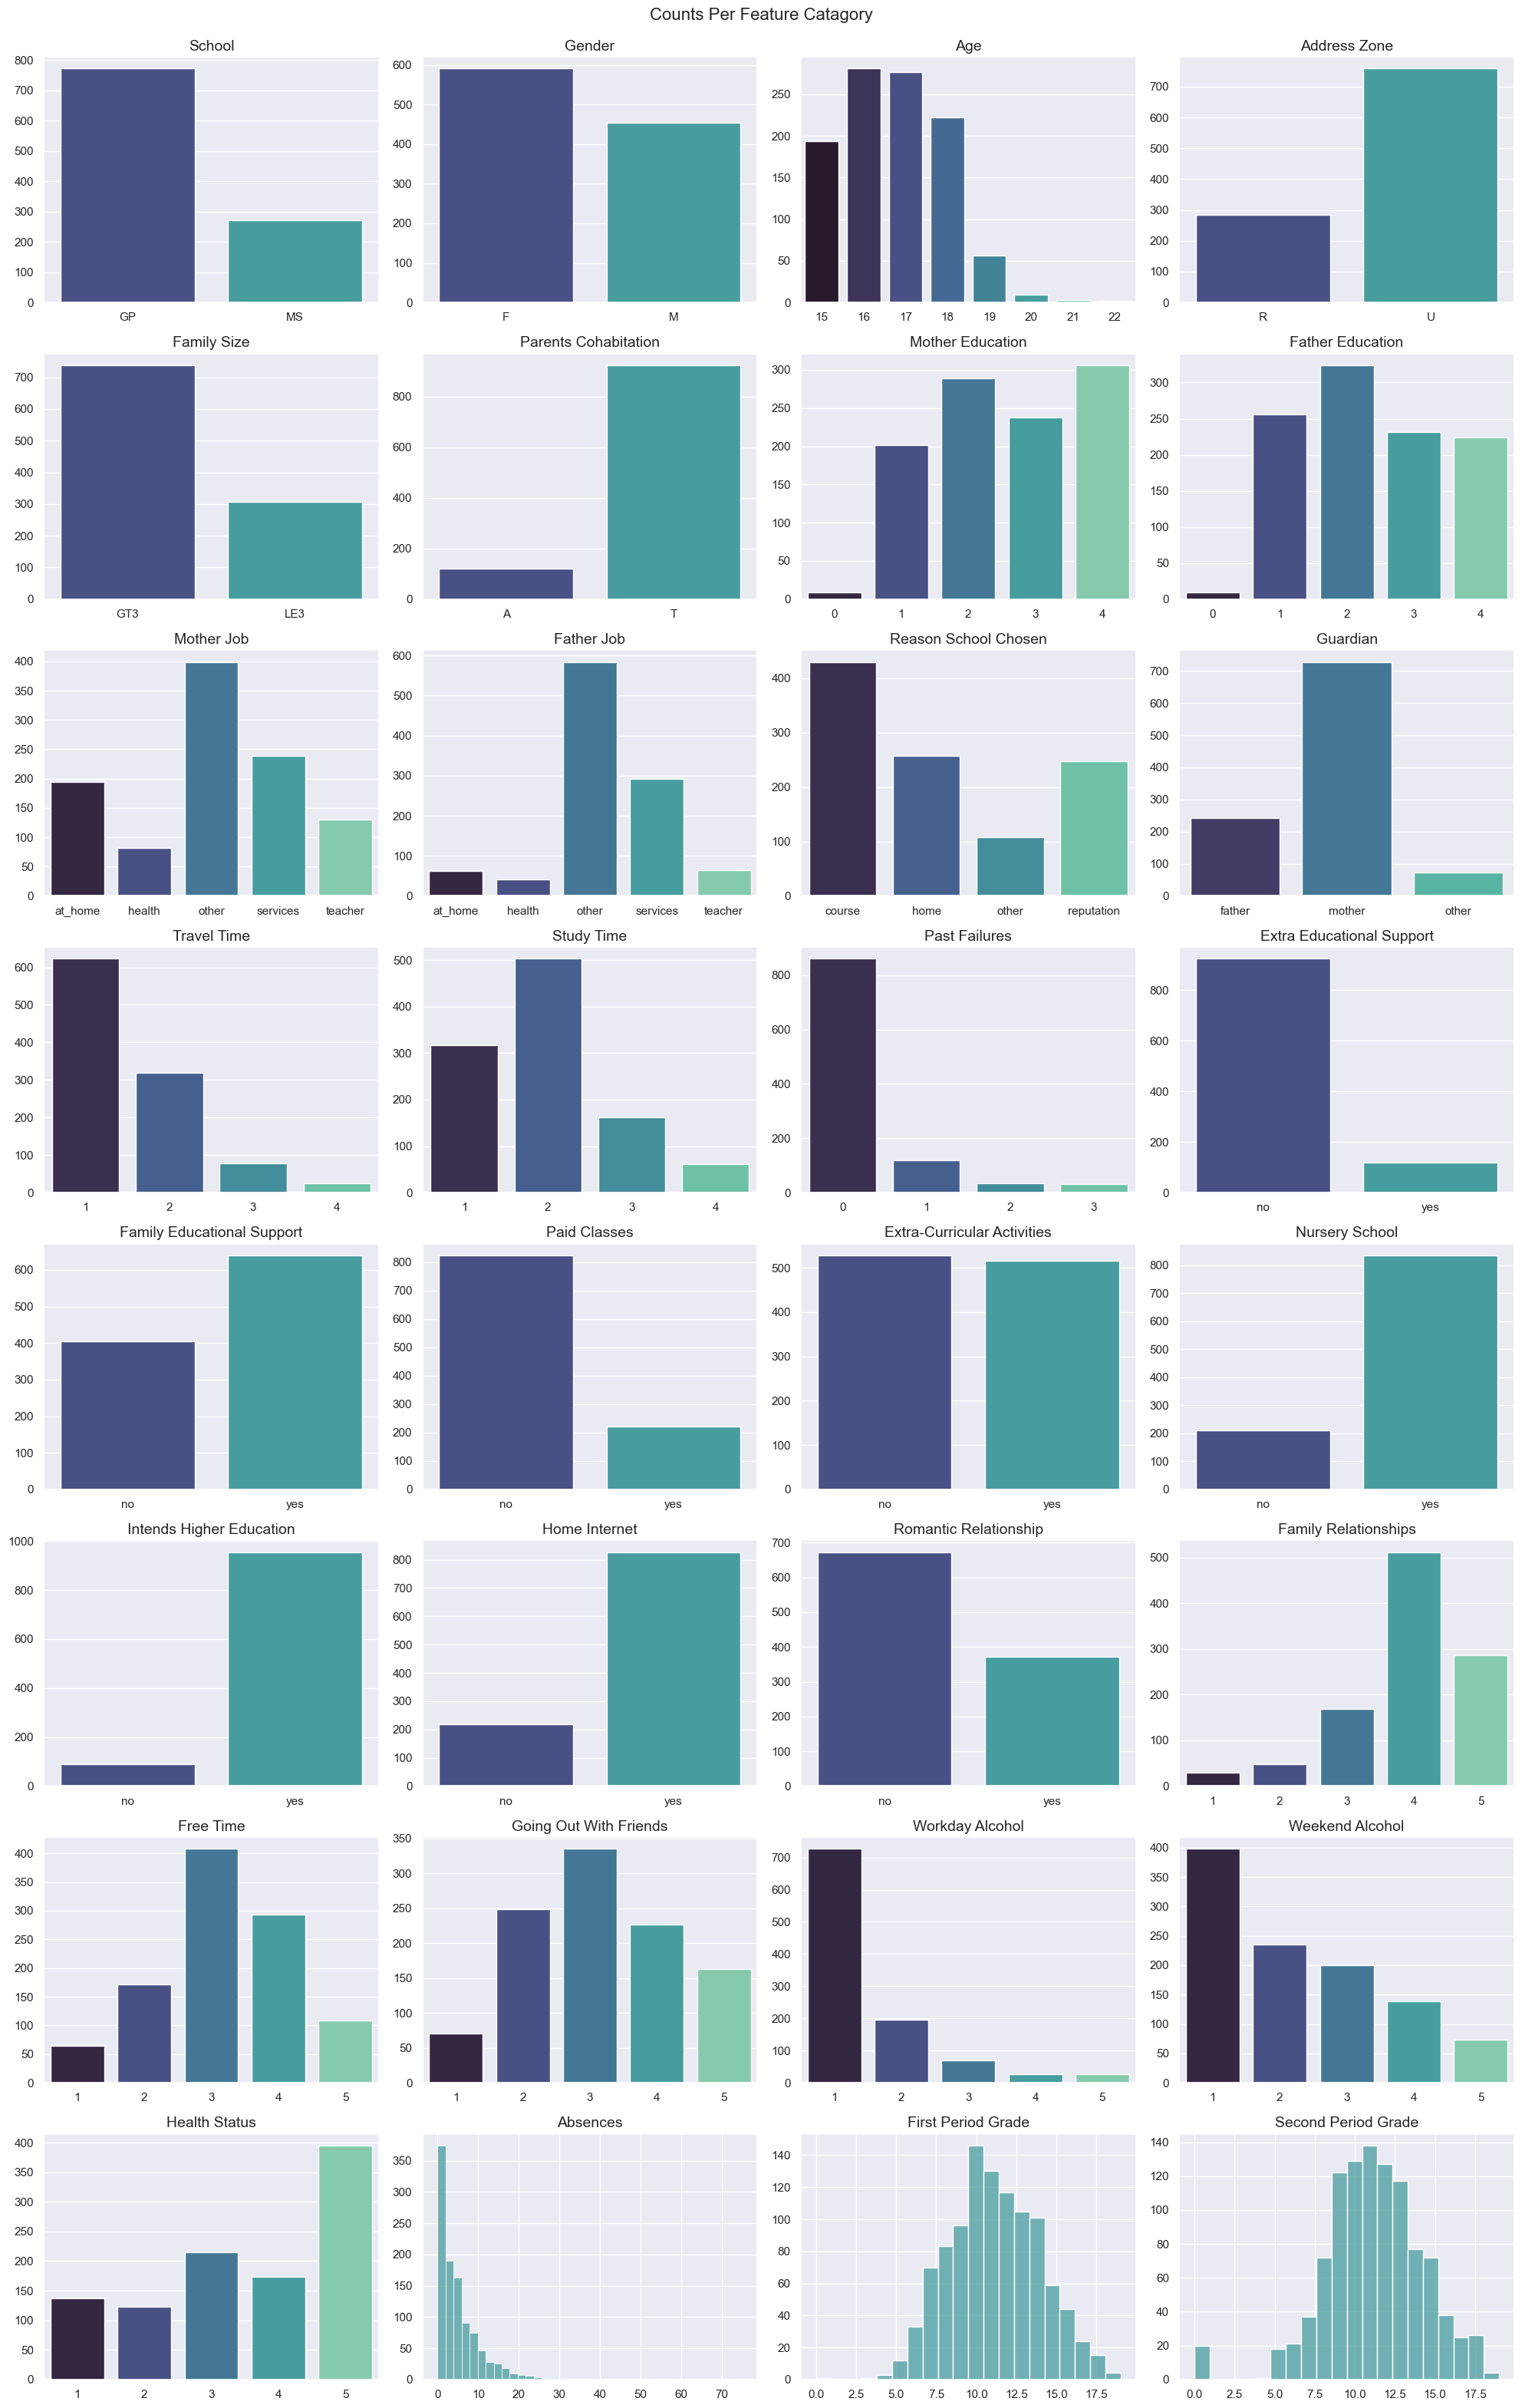

In [5]:
# Graph counts by feature catagories.
def plot_cat_count() -> None:
    """
    Graph the count for each catagory in each feature
    """
    nrows = math.ceil(len(students.columns[:-1])/4)
    fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(20, nrows*4))

    for i, feature in enumerate(students.columns[:-1]):
        if feature not in ('absences', 'G1', 'G2'):
            myplot = sns.barplot(x=np.msort(students[feature].unique()), 
                                 y=students[feature].value_counts().sort_index(), 
                                 palette=palette, ax=axs[int((i-i%4)/4)][i%4])
            myplot.set_title(feature_desc[feature], fontdict={'fontsize':14})
        else:
            bins = 38 if feature == 'absences' else 20
            myplot = sns.histplot(x=students[feature], bins=bins, ax=axs[int((i-i%4)/4)][i%4], color=color)
            myplot.set_title(feature_desc[feature], fontdict={'fontsize':14})

    for ax in axs.flat:
        ax.set(xlabel='', ylabel='')     
            
    fig.suptitle('Counts Per Feature Catagory', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.96)
    plt.show()

display(Markdown("### Compare Feature Catagory Distribution"))
print()
plot_cat_count()

### Compare Feature Category Density Distribution Of Final Test Scores

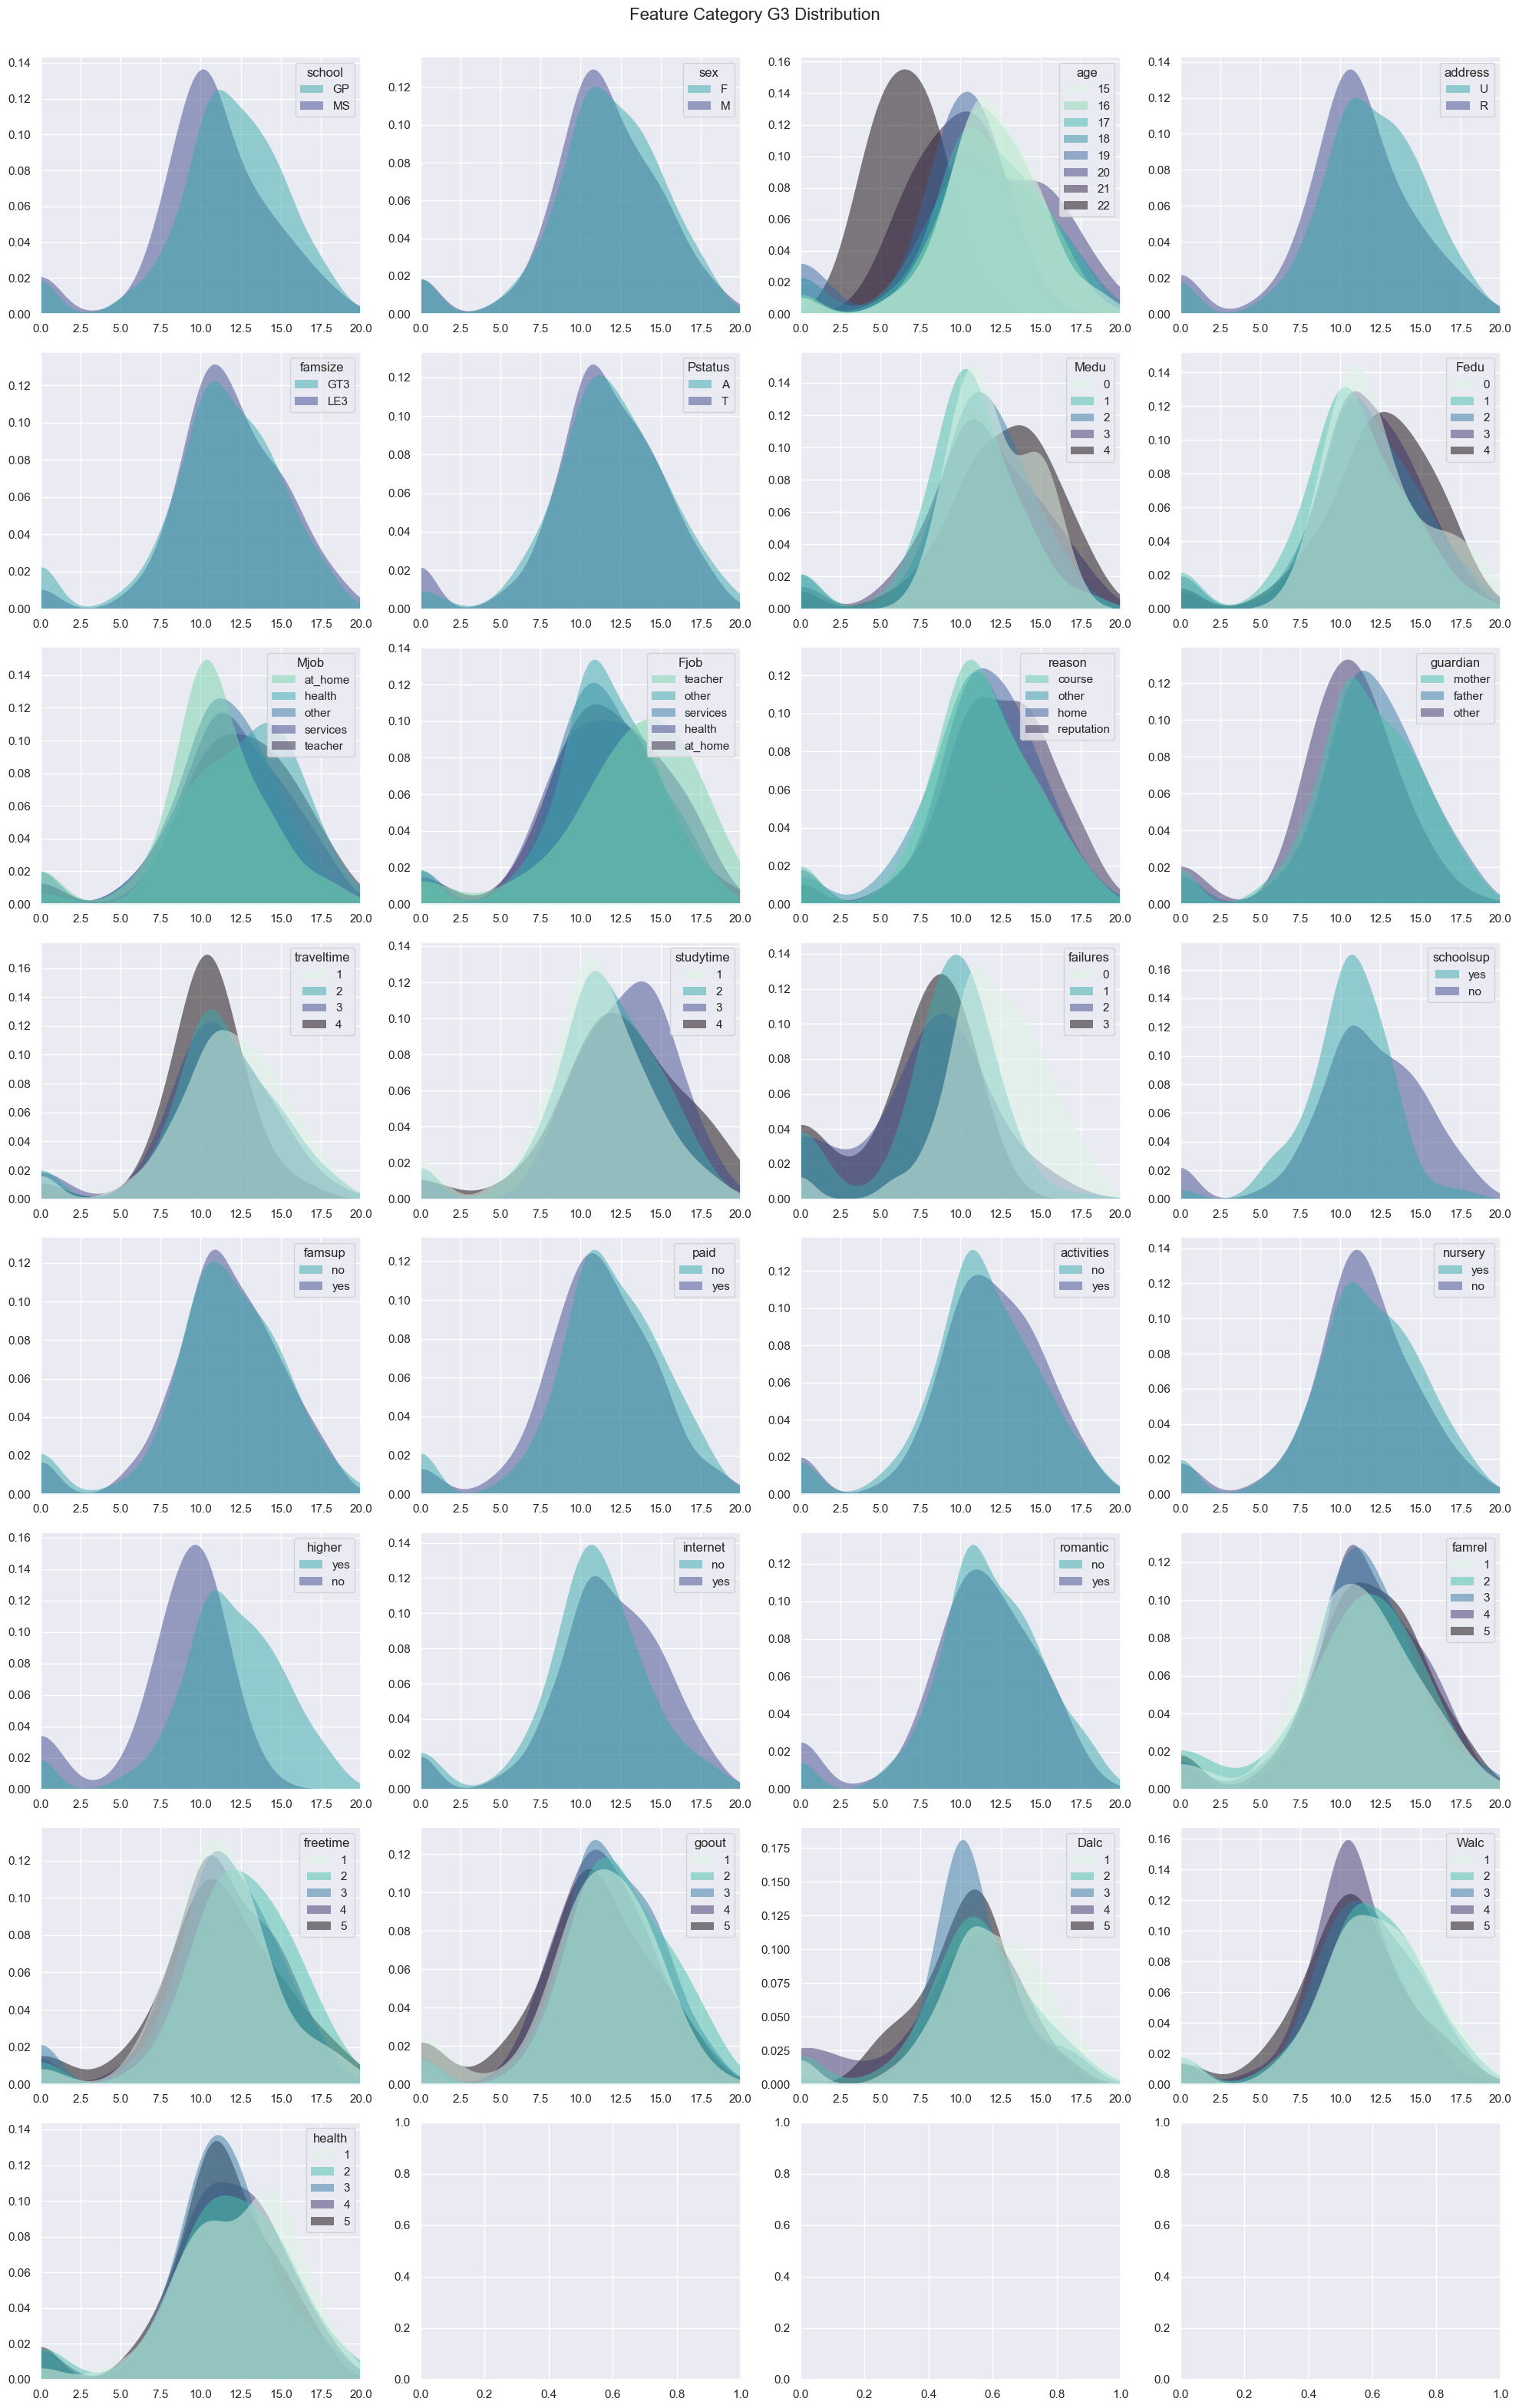

In [6]:
# Graph distribution of G3 scores by feature catagories.
def plot_kde() -> None:
    nrows = math.ceil(len(df.columns[:-1])/4)
    fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(20, nrows*4))

    for i, feature in enumerate(df.columns[:-1]):
        if feature not in ('absences', 'G1', 'G2'):
            myplot = sns.kdeplot(data=df, x="G3", hue=feature, 
                                 shade=True, fill=True, common_norm=False, 
                                 palette=cmap, alpha=.5, linewidth=0, 
                                 ax=axs[int((i-i%4)/4)][i%4])
            myplot.set_xlim([0, 20])

    for ax in axs.flat:
        ax.set(xlabel='', ylabel='')
        
            
    fig.suptitle('Feature Category G3 Distribution', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.96)
    
    plt.show()

display(Markdown("### Compare Feature Category Density Distribution Of Final Test Scores"))
print()
plot_kde()

In [7]:
# Calculate statistical values for G3 scores by feature catagories.
def feature_score_stats(features: list[str]) -> dict[str, dict]:
    '''
    Calculate G3 mean, median, standard deviation, min and max scores, count, and portion of total for each catagory within each feature.
    '''
    feature_dict = {}
    
    for feature in features:
        grouped = students.groupby(feature)
        catagory_dict = {}
        
        for cat in grouped.mean().index:
            catagory_dict[cat] = [grouped.mean()['G3'][cat], 
                                  grouped.median()['G3'][cat], 
                                  grouped.std(ddof=0)['G3'][cat],
                                  grouped.min()['G3'][cat], 
                                  grouped.max()['G3'][cat], 
                                  grouped.count()['G3'][cat], 
                                  grouped.count()['G3'][cat] / students['G3'].count()]
        feature_dict[feature] = catagory_dict
            
    return feature_dict

features_stats = feature_score_stats(students.columns[:-1])

### Compare Feature Category Central Tendency Of Final Test Scores

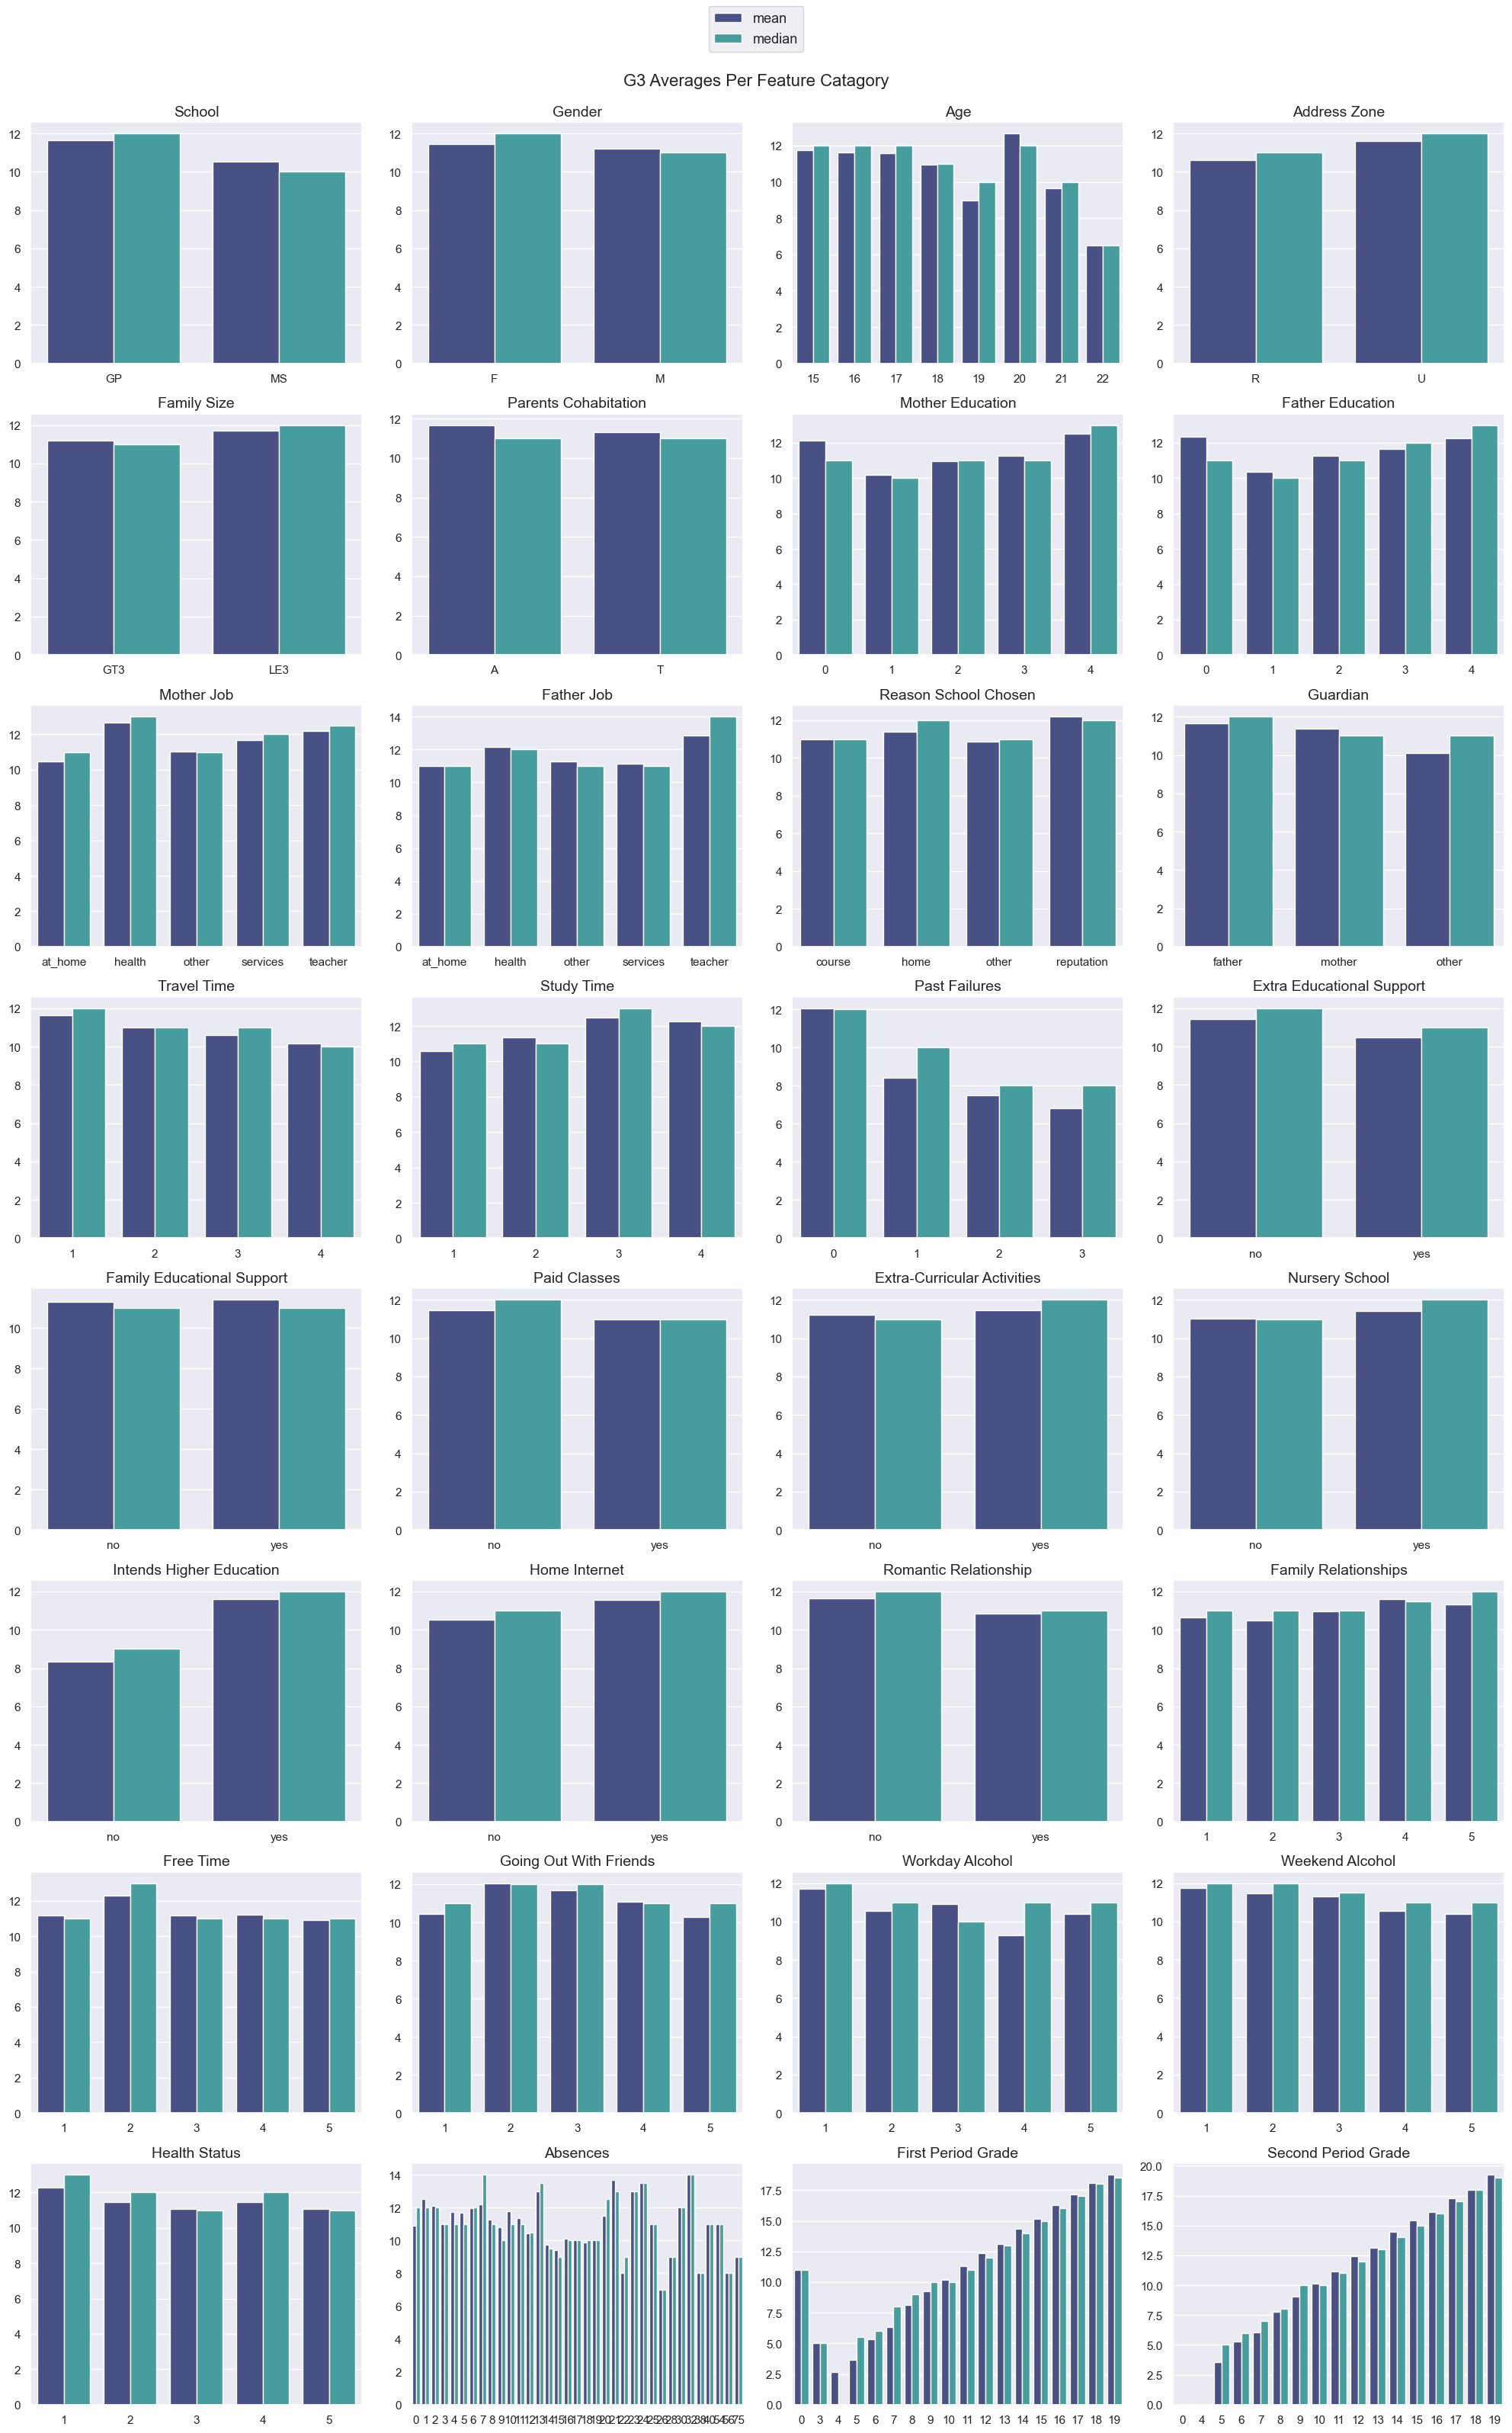

In [8]:
# Graph G3 statistical center values by feature catagories.
def plot_mean_median(feature_stats: dict[str, dict]) -> None:
    """
    Graph the G3 mean and median for each feature catagory.
    """
    nrows = math.ceil(len(features_stats)/4)
    fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(20, nrows*4))
    
    for i, (feature, catagories) in enumerate(features_stats.items()):
        ax = axs[int((i-i%4)/4)][i%4]
        
        df_cat = pd.DataFrame(catagories)[0:2].T.reset_index()
        df_cat.rename(columns = {0:'mean', 1:'median'}, inplace=True)
        df_cat = df_cat.melt(id_vars='index')
        
        myplot = sns.barplot(data=df_cat, x='index', y='value', hue='variable', ax=ax, palette=palette)
        myplot.set_title(feature_desc[feature], fontdict={'fontsize':14})
        handles, labels = myplot.get_legend_handles_labels()
        myplot.legend_.remove()
        
    for ax in axs.flat:
        ax.set(xlabel='', ylabel='')

    fig.suptitle('G3 Averages Per Feature Catagory', y=0.97, fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.legend(handles, labels, loc='upper center', fontsize=13)
    plt.show()
    
display(Markdown("### Compare Feature Category Central Tendency Of Final Test Scores"))
print()
plot_mean_median(features_stats)

An initial cursory exploration of the data reveals little in the way of actionable insights. The standouts amoung the few features showing a relatively significant gap between high and low mean values within feature catagories are:
* Past Failures
* Intends Higher Education
* Absenses

These features are a good start as 'red flag' indicators for identifying those in need of intervention measures. Further examination would be required to focus in on those specific students who are most at risk and would most benefit from the expenditure of limited funds . However, the time, attention, and personnel required to perform such an in-depth investigation tends to be greater than the available resources. As well, delays in implementation anywhere along the intended course serve to further exacerbated the situation and puts vulnerable students at even greater risk.

Further exploration may provide additional understanding and disclose opportunities not yet uncovered.


In [9]:
# Graph and display distribution metrics for each feature catagory G3 scores.
def print_feature_header(feature: str) -> None:
    """
    Print header for feature catagory statistics.
    """
    print(f"{feature:<12}", end='')
    print(f"{'Count':<8}", end='')
    print(f"{'Min - Max':<12}", end='')
    print(f"{'Mean':<10}", end='')
    print(f"{'Median':<11}", end='')
    print(f"{'Stdev':<9}", end='')
    print(f"{'Portion':<15}")
    print(f"{'-'*len(feature):<12}{'-'*57}")    
    
def print_feature_stats(catagories: dict[str, list[float or int]]) -> None:
    """
    Print formatted feature catagory statistics.
    """
    for cat, stats in catagories.items():
        print(f"{cat:<12}", end='')
        print(f"{stats[5]:>3}", end=' '*5)
        print(f"{str(stats[3]).zfill(2):>2} - {str(stats[4]).zfill(2):>2}", end=' '*5)
        print(f"{stats[0]:>5.2f}", end=' '*5)
        print(f"{stats[1]:>5.2f}", end=' '*5)
        print(f"{stats[2]:>5.2f}", end=' '*5)
        print(f"{stats[6]*100:>5.2f}%")

def display_plots(feature: str, cnt: int) -> None:
    """
    Print individual boxplots for each catagory of the represented feature.
    """
    rows = math.ceil(cnt/5)
    cols = 5 if rows > 1 else cnt
    
    print('Distribution')
    print('-'*(cols*13 + 2))
    
    fig, ax = plt.subplots(figsize=(100*px*cols + (50*px/cols), 220*px*rows))
    df.groupby(feature).boxplot(column='G3', layout=(rows,cols), widths=0.5, ax=ax, **props)
    fig.tight_layout()
    plt.show()
    
    
px = 1/plt.rcParams['figure.dpi']  # pixels in inches
props = {'boxprops': {'lw':3, 'c':'#495084'}, 
         'medianprops': {'lw':3, 'c':'#479c9e'},
         'whiskerprops': {'lw':3, 'c':'#495084'}, 
         'capprops': {'lw':3, 'c':'#495084'}, 
         'flierprops': {'marker':'o', 'markerfacecolor':'#d62728'}}
    
display(Markdown("### Compare Feature Catagory Summary Statistics Of Final Test Scores"))
print()
print(f"{'Final Test Scores Summary':<25}")
print('_'*25)

out_G3 = Output()
with out_G3:
    print(df['G3'].describe().apply("{0:.2f}".format).reset_index().to_string(header=None, index=None), end=' '*6)
    
out_G3_plot = Output()
with out_G3_plot:
    df.boxplot(column='G3', widths=0.5, figsize=(120*px,216*px), **props)
    plt.show()

display(HBox([out_G3, out_G3_plot]))

print(f"\nFeature Catagory Final Test Scores Summary")
print('_'*42)

for feature, catagories in features_stats.items():
    if feature not in ['absences', 'G1', 'G2']:
        out_cats = Output()
        with out_cats:
            print_feature_header(feature)
            print_feature_stats(catagories)

        out_cats_plots = Output()
        with out_cats_plots:
            display_plots(feature, len(catagories))

        display(HBox([out_cats, out_cats_plots]))

### Compare Feature Catagory Summary Statistics Of Final Test Scores


Final Test Scores Summary
_________________________



Feature Catagory Final Test Scores Summary
__________________________________________


### Compare Feature Correlation

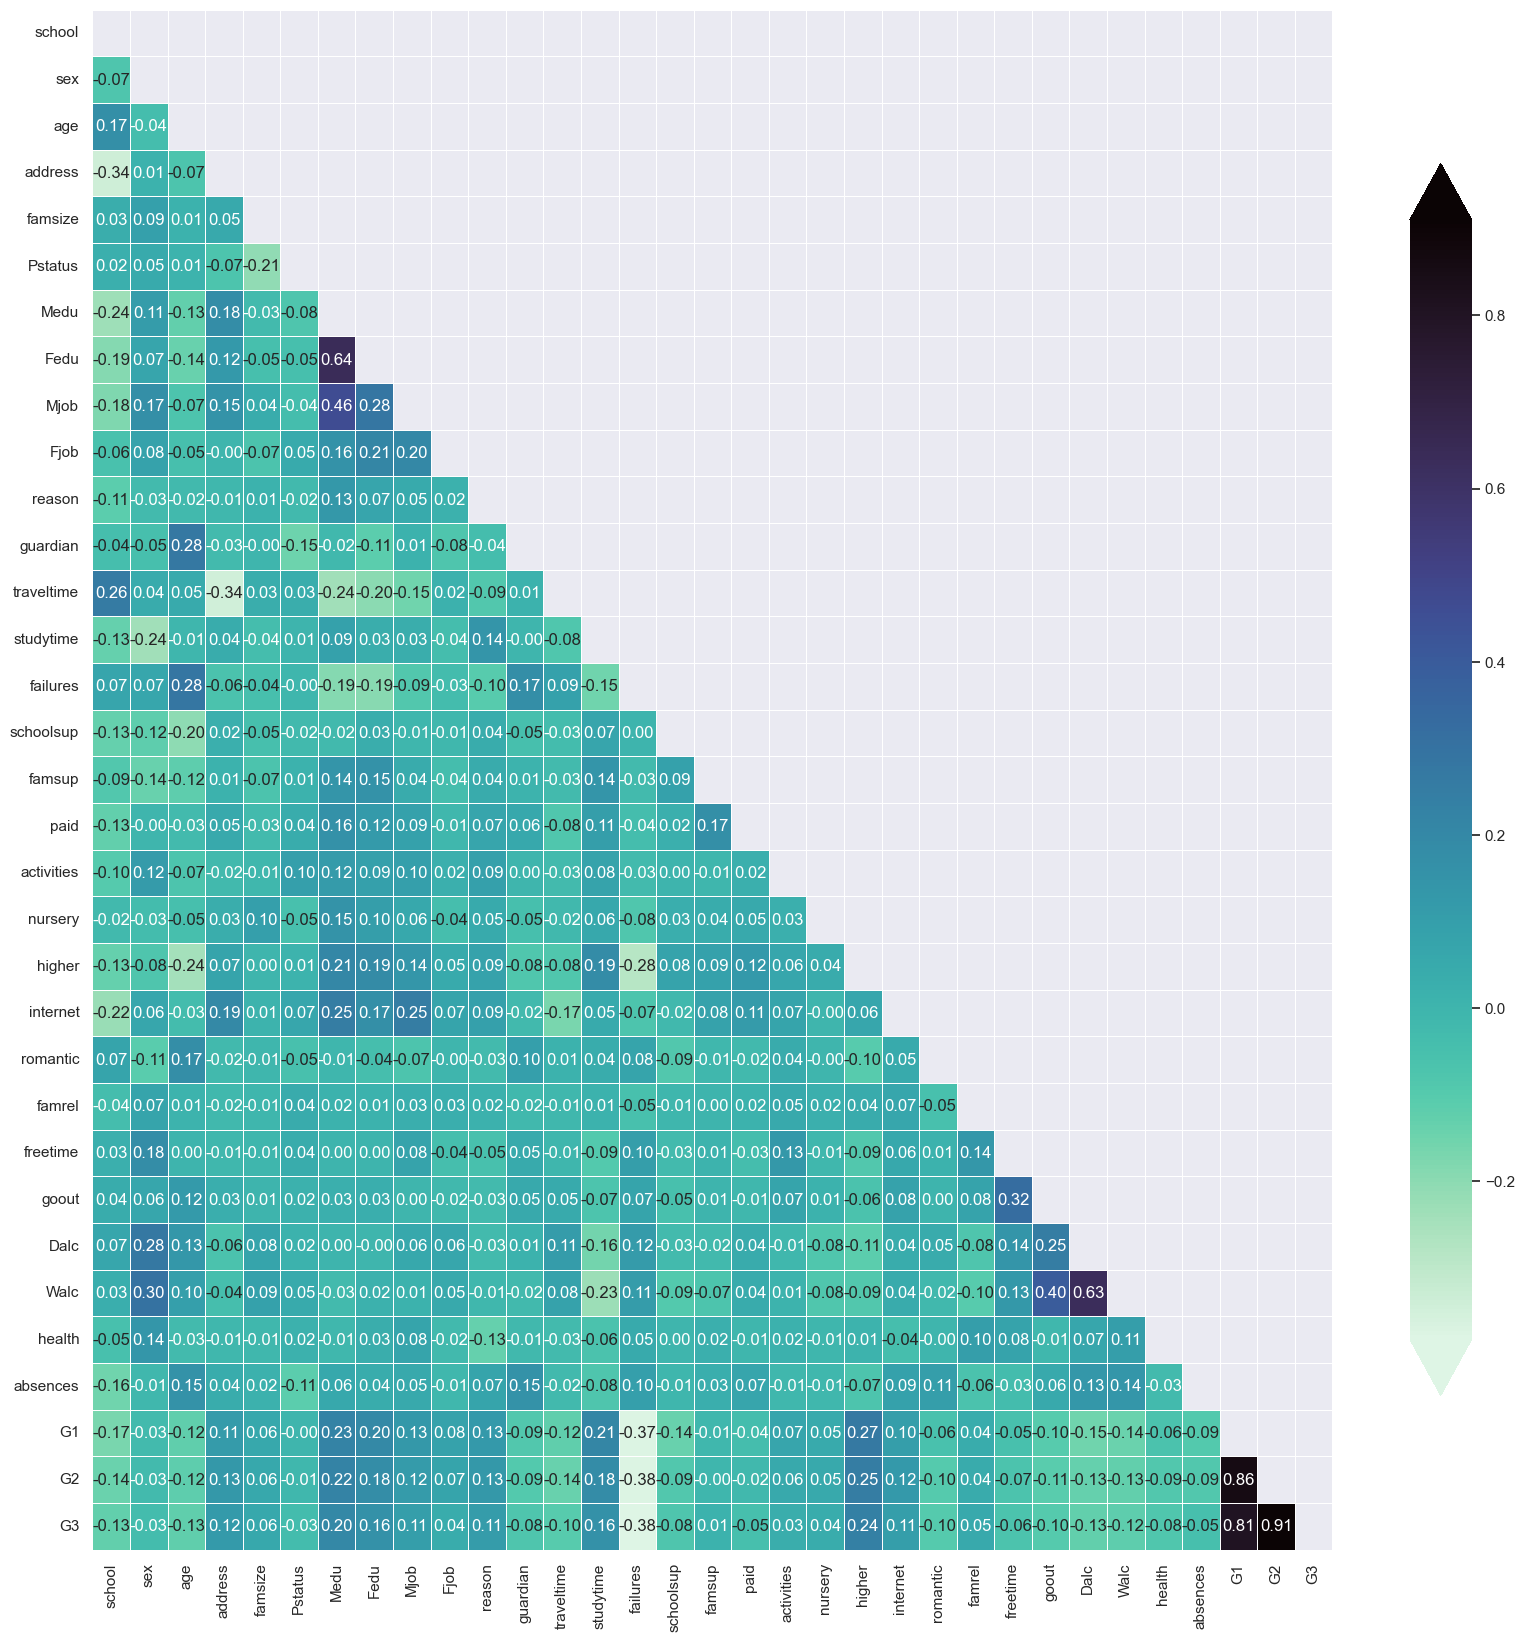

In [10]:
# Graph feature correlation.
display(Markdown("### Compare Feature Correlation"))
print()
# Convert text data to integers
for label, content in students.items():
    if pd.api.types.is_string_dtype(content):
        students[label] = pd.Categorical(students[label]).codes

# Display a heatmap of feature correlation  
corr_matrix = students.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

cbar_kws = {"shrink":.8,
           'extend':'both'}
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt='.2f', cmap=cmap, mask=mask, cbar_kws=cbar_kws)
plt.show()

Most of the insights found here, upon reflection, are rather obvious. For example, the correlation between Medu and Fedu or between Dalc and Walc are to be expected and of little value in uncovering anything relevant to the task of predicting academic performance.

While it may be useful to spend the time in an exhaustive study of the details derived from the data just laid out...due to the complexity of the task, a more productive exercise would probably be to move on and see what machine learning can make of it.


In [11]:
# Convert grades to standard A-E (4-0) grading system
grades = {0: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), 1: (12, 13), 2: (14, 15), 3: (16, 17), 4: (18, 19, 20)}
students_grades = students[:]
    
for grade, scores in grades.items():
    students_grades['G3'] = np.where(np.isin(students_grades['G3'], scores), grade, students_grades['G3'])
    students_grades['G2'] = np.where(np.isin(students_grades['G2'], scores), grade, students_grades['G2'])
    students_grades['G1'] = np.where(np.isin(students_grades['G1'], scores), grade, students_grades['G1'])

In [12]:
# Helper functions
from IPython.display import HTML

def print_header():
    print(f"\n{'Model':<30}{'Accuracy':<30}Cross Validation")
    print(f"{'-'*5:<30}{'-'*8:<30}{'-'*16}")

def print_score(name, scores):
    print(f"{name:<30}", end='')
    for score in scores:
        print(f"{score:<30}", end='')
    print()

def get_X_y(df, drop_list, target):
    return df.drop(drop_list, axis='columns'), df[target]

def split_data(X_data, y_data):
    return train_test_split(X_data, y_data, test_size=test_fraction, random_state=random_seed)

def scale_data(train_data, test_data):
    scaler = StandardScaler()
    fitted_scaler = scaler.fit(train_data)
    return fitted_scaler.transform(train_data), fitted_scaler.transform(test_data)

def train_classifier(classifier, X_data, y_data):
    model = classifier
    model.fit(X_data, y_data)
    return model

def validation_score(n_splits, classifier, X_data, y_data):
    scaler = StandardScaler()
    pipeline = Pipeline([('transformer', scaler), ('estimator', classifier)])
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    per_fold_acc = cross_val_score(pipeline, X_data, y_data, cv = cv, scoring='accuracy')
    return np.mean(per_fold_acc)

# Add a 'pass' column to the dataset to contain a pass/fail binary value based on the average of the three test grades: G1, G2, G3.
def convert_pass_fail(df, grade_value):
    df_copy = df.copy().reset_index().drop('index', axis=1)
    df_copy['average'] = np.floor(df[['G3', 'G2', 'G1']].sum(axis=1) / 3)
    
    for grade, scores in grades.items():
        df_copy['average'] = np.where(np.isin(df_copy['average'], scores), grade, df_copy['average'])
    
    df_copy['pass'] = np.where(df_copy['average'] >= grade_value, 1, 0)
    
    df_copy = df_copy.drop('average', axis='columns')
    return df_copy

In [13]:
# List of classifiers to use in model comparisons.
def get_classifiers():
    names = ["Support Vector Machine", 
            "Logistic Regression",
            "Gradient Boosting", 
            "XGBoost Classifier"
            ]

    classifiers = [
        SVC(probability=True),
        LogisticRegression(),
        GradientBoostingClassifier(),
        XGBClassifier()
        ]
    return [names, classifiers]

# Trains each classifier on the train data, makes predictions on the test data, and returns scores:
# accuracy classification score and cross validation score.
def model_scores(df, drop_list, label, clfs):
    scores1 = defaultdict(list)
    scores2 = defaultdict(list)
    
    names, classifiers = clfs
    
    for _ in range(num_trials):
        X, y = get_X_y(df, drop_list, label)
        X_train, X_test, y_train, y_test = split_data(X, y)
        X_train, X_test = scale_data(X_train, X_test)

        for name, classifier in zip(names, classifiers):
            model = train_classifier(classifier, X_train, y_train)
            y_preds = model.predict(X_test)
            score = accuracy_score(y_test, y_preds)
            scores1[name].append(score)

        for name, classifier in zip(names, classifiers):
            score = validation_score(cv_splits, classifier, X, y)
            scores2[name].append(score)
            
    return scores1, scores2

# Displays each classification model's scores for comparison.
def display_scores(heading, scores1, scores2):
    mean1 = np.mean(list(scores1.values()))
    mean2 = np.mean(list(scores2.values()))
    scores = defaultdict(list)
    
    for name in scores1.keys():
        scores[name].append(np.mean(scores1[name]))
        scores[name].append(np.mean(scores2[name]))

    score_out = Output(layout={'border': '2px solid black', 'width': '580px'})
    with score_out:
        print(heading)
        print('_'*len(heading))
        print_header()    
        for name, score_list in scores.items():
            print_score(name, score_list)
        print()
        print(f"{'Averaged':<30}{mean1:<30}{mean2}")
    return score_out

In [14]:
# Display model prediction accuracy scores of final test scores

classifiers = get_classifiers()
heading = "With 1st And 2nd Period Scores"
drop_list = ['G3']
target = 'G3'
scores1, scores2 = model_scores(students_grades, drop_list, target, classifiers)
score_out1 = display_scores(heading, scores1, scores2)

heading = "Without 1st And 2nd Period Scores"
drop_list = ['G1', 'G2', 'G3']
scores1, scores2 = model_scores(students_grades, drop_list, target, classifiers)
score_out2 = display_scores(heading, scores1, scores2)

display(Markdown("### Model Predictions Of Final Test Scores"))
print()
display(score_out1)
print('_'*81, end='\n\n')
display(score_out2)
print('_'*81, end='\n\n')

### Model Predictions Of Final Test Scores

Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



As can be seen from the above results, previous test grades contribute greatly to the achievable predictive ability of the model. 
However, outcomes heavily reliant on previous test grades to predict future test grades are 1) to be expected, 2) not very satisfying in terms of knowledge gained, and 3) of limited use overall.

* `From this point on, the models will train on data without 1st and 2nd period grades.`
* `To better focus on at-risk students, a pass/fail criteria is used in all the following predictions.`
* `To further parse the data for a more refined analysis, the data is split into seperate female and male data sets.`

In [15]:
# After using a pass/fail criteria and splitting the data set between female and male students.

def get_classifiers():
    names = ["Support Vector Machine", 
            "Logistic Regression",
            "Gradient Boosting", 
            "XGBoost Classifier"
            ]

    classifiers = [
        SVC(probability=True),
        LogisticRegression(),
        GradientBoostingClassifier(),
        XGBClassifier(objective="multi:softmax", num_class=2)
        ]
    return [names, classifiers]
    
classifiers = get_classifiers()

pass_fail = convert_pass_fail(students, passing_score)

female = pass_fail[pass_fail['sex'] == 0]
male = pass_fail[pass_fail['sex'] == 1]
drop_list = ['G1', 'G2', 'G3', 'pass']
target = 'pass'

# scores = defaultdict(list)
heading = "Students On Pass/Fail Basis"
scores1, scores2 = model_scores(pass_fail, drop_list, target, classifiers)
score_out1 = display_scores(heading, scores1, scores2)

# Compare female and male classifiers.
drop_list = ['sex', 'G1', 'G2', 'G3', 'pass']

# scores = defaultdict(list)
heading = "Female Students On Pass/Fail Basis"
scores1, scores2 = model_scores(female, drop_list, target, classifiers)
score_out2 = display_scores(heading, scores1, scores2)

# scores = defaultdict(list)
heading = "Male Students On Pass/Fail Basis"
scores1, scores2 = model_scores(male, drop_list, target, classifiers)
score_out3 = display_scores(heading, scores1, scores2)

display(Markdown("### Model Predictions On Pass/Fail Basis And By Gender"))
print()
display(score_out1)
print('_'*81, end='\n\n')
display(score_out2)
print('_'*81, end='\n\n')
display(score_out3)
print('_'*81, end='\n\n')

### Model Predictions On Pass/Fail Basis And By Gender

Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



Having determined that the pass/fail basis strategy of student performance prediction produces an acceptable accuracy score, further examination using parameter tuning is deemed warranted. As well, when the data set is split into female and male data sets, the predictive ability of the models show a distinct disparity between genders, favoring the male data set.

In [16]:
# After hyperparameter tuning using GridSearchCV

def get_classifier_names():
    return ["Support Vector Machine", 
            "Logistic Regression",
            "Gradient Boosting", 
            "XGBoost Classifier"]

def get_tuned_classifiers(gender):
    # C, gamma, lr, l_r, sub, m_cw, m_d, gma = [1.0, 'scale', 0.1, 0.1, 0.6, 5, 4, 1] if gender == 'Female' else [10, 0.1, 0.05, 0.01, 1.0, 10, 2, 5]
    C, gamma = [1.0, 'scale'] if gender == 'Female' else [10, 0.1]
    classifiers = [
        SVC(C=C, gamma=gamma, kernel='rbf', probability=True),
        LogisticRegression(),
        GradientBoostingClassifier(),
        # XGBClassifier(max_depth=m_d, learning_rate=l_r, subsample=sub, min_child_weight=m_cw, gamma=gma),
        XGBClassifier()
        ]
    return classifiers

# Compare classifiers for female and male data sets.
scores = defaultdict(list)
names = get_classifier_names()

classifiers = [names, get_tuned_classifiers('Female')]
heading = "Female Parameter Tuned"
scores1, scores2 = model_scores(female, drop_list, target, classifiers)
score_out1 = display_scores(heading, scores1, scores2)

for name in names:
    scores[name].append(scores1[name])
    scores[name].append(scores2[name])
    
classifiers = [names, get_tuned_classifiers('Male')]
heading = "Male Parameter Tuned"
scores1, scores2 = model_scores(male, drop_list, target, classifiers)
score_out2 = display_scores(heading, scores1, scores2)

for name in names:
    scores[name].append(scores1[name])
    scores[name].append(scores2[name])

display(Markdown("### Model Predictions After Parameter Tuning"))
print()
display(score_out1)
print('_'*81, end='\n\n')
display(score_out2)
print('_'*81, end='\n\n')
score_out3 = Output(layout={'border': '2px solid black', 'width': '580px'})
with score_out3:
    heading = "Female/Male Combined Averages"
    print(heading)
    print('_'*len(heading))
    print(f"\n{'Model':<30}{'Averages':<30}")
    print(f"{'-'*5:<30}{'-'*8:<30}")
   
    for name in names:
        mean_score = np.mean(list(scores[name]))
        print(f"{name:<30}{mean_score}")
        scores[name] = mean_score
    
    max_average = max(scores, key = scores.get)
    print(f"\n{'Highest Accuracy':<30}{max_average:<25}{scores[max_average]}")

display(score_out3)
print('_'*81, end='\n\n')

### Model Predictions After Parameter Tuning

Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



Parameter tuning shows only minor improvements to the model predictive abilities. This is primarily due to the fact that only the Support Vector Machine model showed improvements after parameter tuning compared to the default settings. Even so, the accuracy scores produced by the models show an acceptable level of predictability.

The accuracy score acceptability of the model predictions above are as follows (with scores rounded to the nearest percentage):
* Female Parameter Tuned - XGBoost Classifier score of **69%** is in the higher **acceptable** range. 
* Male Parameter Tuned - Support Vector Machine and Gradient Boosting score of **85%** is in the higher **good** range.
* Female/Male Combined Averages - XGBoost Classifier score of **74%** is in the lower **good** range.

Due to the predictability disparity between the female and male data sets warranting individualized tailoring and examination, further predictions will focus exclusively on this seperation of the gendered data sets.


### Confusion Matrix And Area Under The Curve Performance

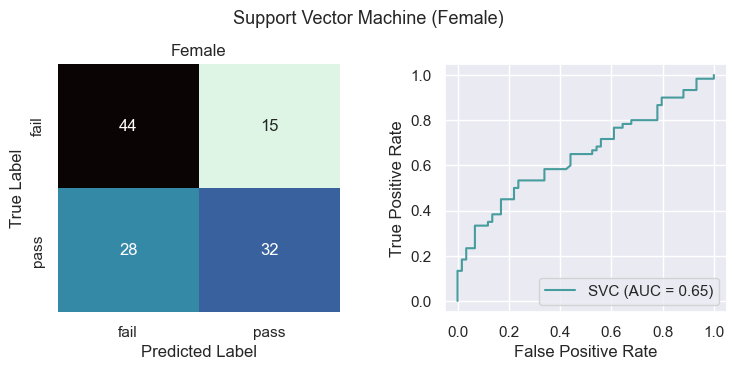

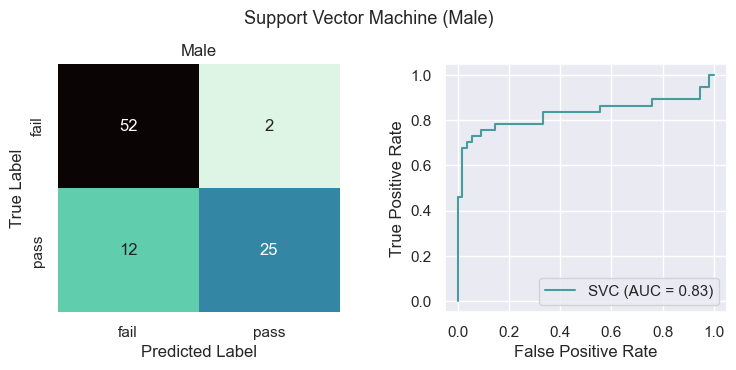

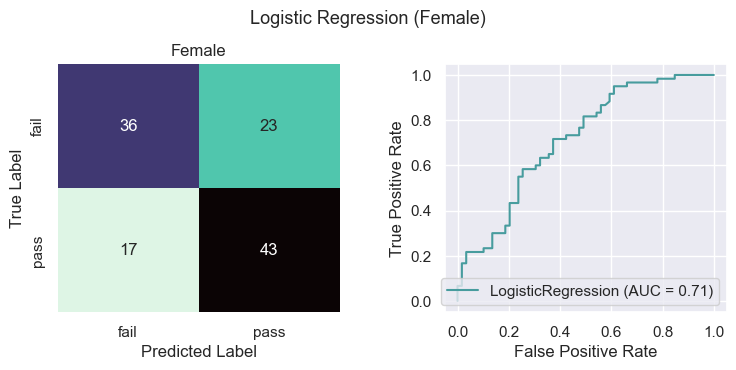

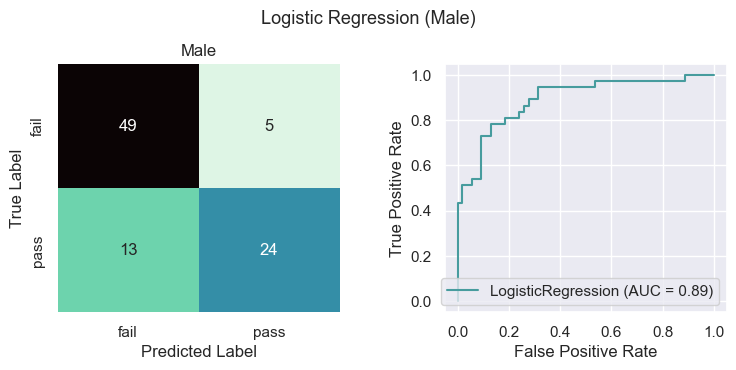

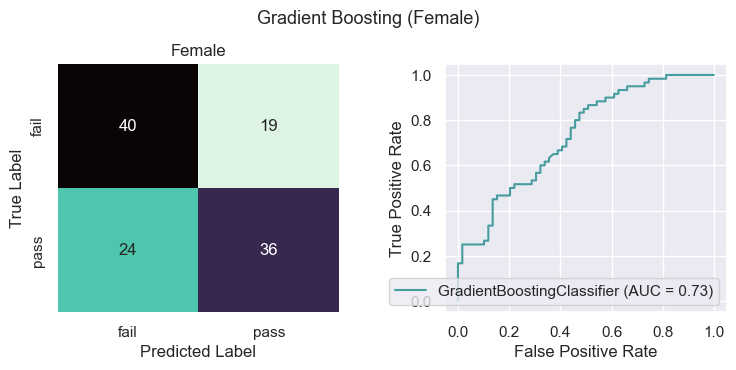

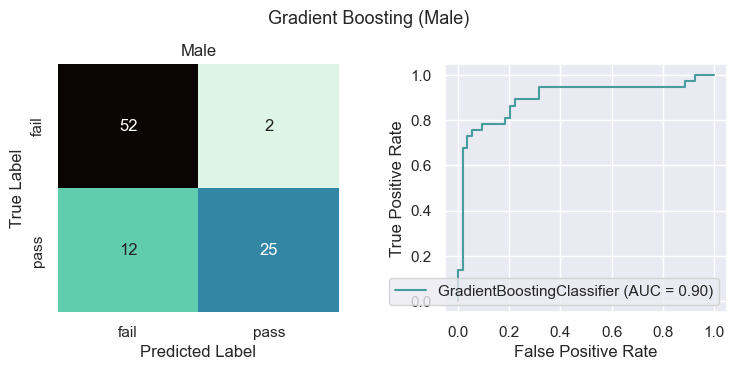

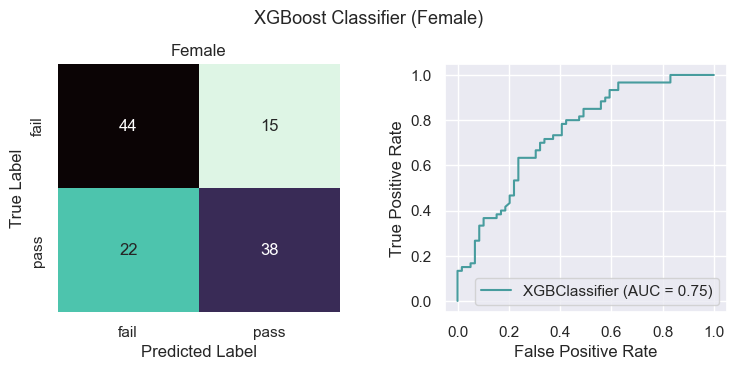

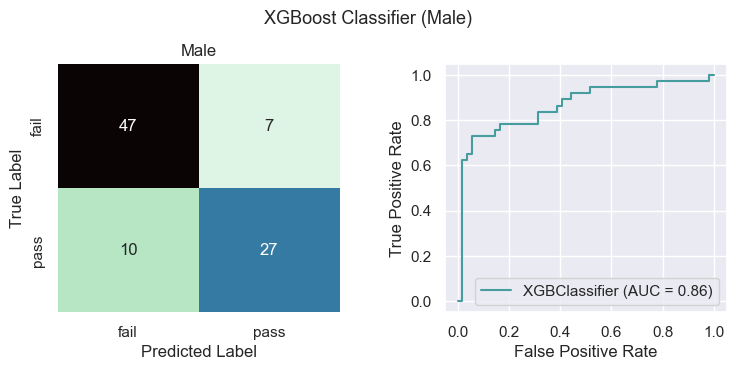

Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



In [17]:
# Calculate AUC metrics and display confusion matrix and ROC curve for each model.
    
def display_auc_scores(gender, scores):
    highest = ['', 0]
    score_out = Output(layout={'border': '2px solid black', 'width': '580px'})
    
    with score_out:
        heading = f"{gender} Area Under The Curve"
        print(heading)
        print('_'*len(heading))
        print(f"\n{'Model':<30}{'ROC AUC'}")
        print(f"{'-'*5:<30}{'-'*7}")
        for name, score in scores:
            print(f"{name:<30}{score}")
            if score > highest[1]:
                highest = [name, score]
        print(f"\n{'Highest ROC AUC':<30}{highest[0]:<25}{highest[1]}")
    return score_out, highest

def get_metrics(gender, df, drop_list, target, classifier, name):
    X, y = get_X_y(df, drop_list, target)
    X_train, X_test, y_train, y_test = split_data(X, y)
    X_train, X_test = scale_data(X_train, X_test)

    model = train_classifier(classifier, X_train, y_train)
    y_preds = model.predict(X_test)
    y_preds_prob = model.predict_proba(X_test)[:,1]
    
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    
    cm = sns.heatmap(confusion_matrix(y_test, y_preds), 
                annot=True, cbar=False, 
                xticklabels=['fail', 'pass'], 
                yticklabels=['fail', 'pass'], 
                ax=axes[0], cmap=cmap)
    
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[1], color=color)
    
    cm.set_xlabel('Predicted Label')
    cm.set_ylabel('True Label')
    cm.set_title(gender.capitalize())
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    fig.tight_layout(pad=2.5, w_pad=3)
    fig.suptitle(f"{name} ({gender.capitalize()})", fontsize=13)
    plt.show()
    return [name, roc_auc_score(y_test, y_preds_prob)]
    
display(Markdown("### Confusion Matrix And Area Under The Curve Performance"))
print()
auc_scores = defaultdict(list)
classifier_names = get_classifier_names()
for classifier_name in classifier_names:
    for gender, df in zip(['female', 'male'], [female, male]):
        for name, tuned_classifier in zip(classifier_names, get_tuned_classifiers(gender)):
            if classifier_name == name:
                auc_scores[gender].append(get_metrics(gender, df, drop_list, target, tuned_classifier, classifier_name))

female_auc, _ = display_auc_scores('Female', auc_scores['female'])
male_auc, _ = display_auc_scores('Male', auc_scores['male'])

print()
display(female_auc)
print('_'*81, end='\n\n')
display(male_auc)
print('_'*81, end='\n\n')



The ROC AUC score acceptability of the model predictions above are as follows (with scores rounded to the nearest percentage):
* Female Area Under The Curve - XGBoost Classifier score of **75%** is in the mid **acceptable** range. 
* Male Area Under The Curve - Gradient Boosting score of **89%** is in the higher **good** range.


In [18]:
# Calculate and display feature importances for each model.

def get_importances(features, classifier, X_data, y_data):
    perm_importance = permutation_importance(classifier, X_data, y_data, n_repeats=30, random_state=random_seed)
    importances = pd.DataFrame({'Features': np.array(features.columns),
                                'Feature Importances': np.abs(perm_importance.importances_mean)}).sort_values(by=['Feature Importances'], 
                                                                                                              ascending=False)
    
    importances2 = pd.DataFrame({'Features': np.array(features.columns),
                                'Feature Importances': perm_importance.importances_mean}).sort_values(by=['Feature Importances'], 
                                                                                                              ascending=False)
    return importances, importances2

def display_feature_importances(name, importance):
    fig, ax = plt.subplots()
    sns.barplot(data=importance, x='Feature Importances', y='Features', palette=cmap, ax=ax)

    ax.set_title(f"{name}")
    ax.set_ylabel('')
    ax.set_xlabel('')

    plt.show()
    
def get_out_plot(gender, df, drop_list, target):
    out_plot = Output()
    importances = {}
    importances2 = {}
    with out_plot:
        header = f"### {gender} Feature Importance"
        display(Markdown(header))
        print('_'*math.floor(len(header)*1.2), end='\n\n')

        X, y = get_X_y(df, drop_list, target)
        X_train, X_test, y_train, y_test = split_data(X, y)
        X_train, X_test = scale_data(X_train, X_test)
        
        names = get_classifier_names()
        classifiers = get_tuned_classifiers(gender)
        for name, classifier in zip(names, classifiers):
            classifier = train_classifier(classifier, X_train, y_train)
            importances[name], importances2[name] = get_importances(X, classifier, X_test, y_test)
        for name, importance in importances.items():
            display_feature_importances(name, importance)
            
    return importances, importances2, out_plot

female_importances, female_importances2, out_plot_female = get_out_plot('Female', female, drop_list, target)
male_importances, male_importances2, out_plot_male = get_out_plot('Male', male, drop_list, target)

display(Markdown("### Compare Feature Importance"))
display(Markdown("Feature importance can be used to isolate those features that make significant contributions to the \
predictions of academic performance. Using this information, the features used in the models can be reduced to only those \
few impactful features. Fewer features mean faster processing speeds and, potentially, higher accuracy scores from the models."))

display(HBox([out_plot_female, out_plot_male]))

### Compare Feature Importance

Feature importance can be used to isolate those features that make significant contributions to the predictions of academic performance. Using this information, the features used in the models can be reduced to only those few impactful features. Fewer features mean faster processing speeds and, potentially, higher accuracy scores from the models.

In [19]:
# Drop features that have a low importance value.
def tailor_dataset_by_importance(df, features, threshold):
    df_copy = df[:]
    features_dict = {}
    count = 0
    for idx, row in features.sort_values('Feature Importances', ascending=False).reset_index(drop=True).iterrows():
        if row['Feature Importances'] >= threshold:
            count += 1
            str_features = (row['Features'], row['Feature Importances']*100)
            features_dict[count] = str_features
        if row['Feature Importances'] < threshold:
            df_copy.drop(row['Features'], axis=1, inplace=True)
    
    return df_copy, features_dict

# Display feature importances greater than designated feature threshold.
importances = defaultdict(list)
importances2 = defaultdict(list)

for model in female_importances.keys():
    df_female, female_features_dict = tailor_dataset_by_importance(female, female_importances[model], feature_threshold)
    df_male, male_features_dict = tailor_dataset_by_importance(male, male_importances[model], feature_threshold)
    
    importances[model].append(df_female)
    importances[model].append(df_male)
    
    df_female2, female_features_dict2 = tailor_dataset_by_importance(female, female_importances2[model], feature_threshold)
    df_male2, male_features_dict2 = tailor_dataset_by_importance(male, male_importances2[model], feature_threshold)
    
    importances2[model].append(df_female2)
    importances2[model].append(df_male2)

In [20]:
# After dimension reduction using feature importance.

def model_score(df, drop_list, target, classifier):
    for _ in range(num_trials):
        X, y = get_X_y(df, drop_list, target)
        X_train, X_test, y_train, y_test = split_data(X, y)
        X_train, X_test = scale_data(X_train, X_test)

        model = train_classifier(classifier, X_train, y_train)
        y_preds = model.predict(X_test)
        
        score1 = accuracy_score(y_test, y_preds)
        score2 = validation_score(cv_splits, classifier, X, y)
            
    return score1, score2

def display_score(heading, scores1, scores2):
    mean1 = np.mean(list(scores1.values()))
    mean2 = np.mean(list(scores2.values()))
    scores = defaultdict(list)
    for name in scores1.keys():
        scores[name].append(np.mean(scores1[name]))
        scores[name].append(np.mean(scores2[name]))

    score_out = Output(layout={'border': '2px solid black', 'width': '580px'})
    with score_out:
        print(heading)
        print('_'*len(heading))
        print_header()    
        for name, score_list in scores.items():
            print_score(name, score_list)
        print()
        print(f"{'Averaged':<30}{mean1:<30}{mean2}")
    return score_out

def importance_scores(importances):
    scores1 = defaultdict(list)
    scores2 = defaultdict(list)
    scores3 = defaultdict(list)
    scores4 = defaultdict(list)
    names = get_classifier_names()
    
    for model, [df_female, df_male] in importances.items():
        tuned_classifiers = get_tuned_classifiers('Female')
        for tuned_model, tuned_classifier in zip(names, tuned_classifiers):
            if tuned_model == model:
                heading = "Female Importances"
                score1, score2 = model_score(df_female, drop_list, target, tuned_classifier)
                scores1[model].append(score1)
                scores2[model].append(score2)
                score_out1 = display_score(heading, scores1, scores2)

        tuned_classifiers = get_tuned_classifiers('Male')
        for tuned_model, tuned_classifier in zip(names, tuned_classifiers):
            if tuned_model == model:
                heading = "Male Importances"
                score3, score4 = model_score(df_male, drop_list, target, tuned_classifier)
                scores3[model].append(score3)
                scores4[model].append(score4)
                score_out2 = display_score(heading, scores3, scores4)
                
    return score_out1, score_out2

display(Markdown("### Model Predictions After Dimension Reduction"))
print()
score_out1, score_out2 = importance_scores(importances)
display(score_out1)
print('_'*81, end='\n\n')
display(score_out2)
print('_'*81, end='\n\n')

### Model Predictions After Dimension Reduction

Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



The accuracy score acceptability of the model predictions above are as follows (with scores rounded to the nearest percentage):
* Female Importances - Gradient Boosting score of **74%** is in the lower **good** range. 
* Male Importances - Gradient Boosting score of **82%** is in the mid **good** range.

Dimension reduction using feature importance had a noticable effect on both female and male accuracy scores from the models. For females the change was positive, increasing the high score by 5 percentage points. For males the change resulted in a 3 percentage point decrease in accuracy. Since the positive change outweighs the negative change, as well as moving the female score into the good range, this is an acceptable trade-off.

### Confusion Matrix And Area Under The Curve Performance After Dimension Reduction

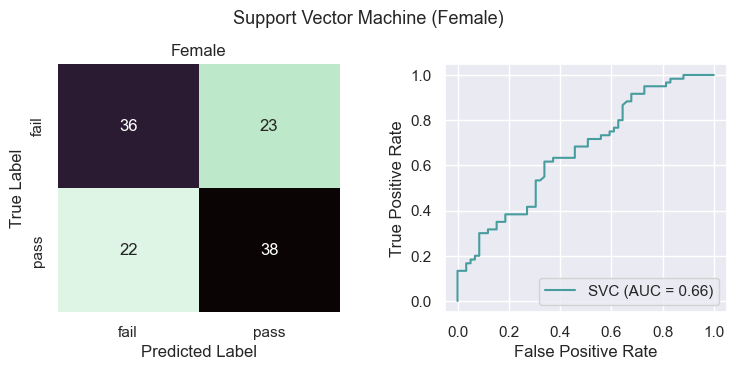

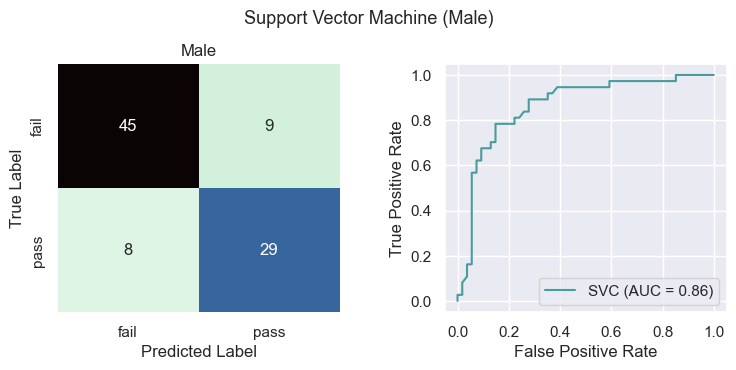

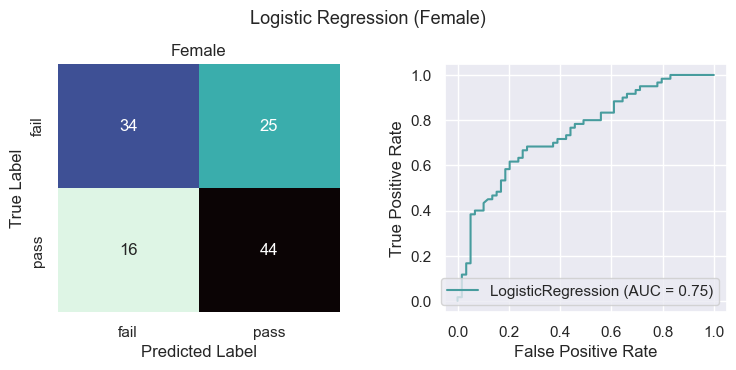

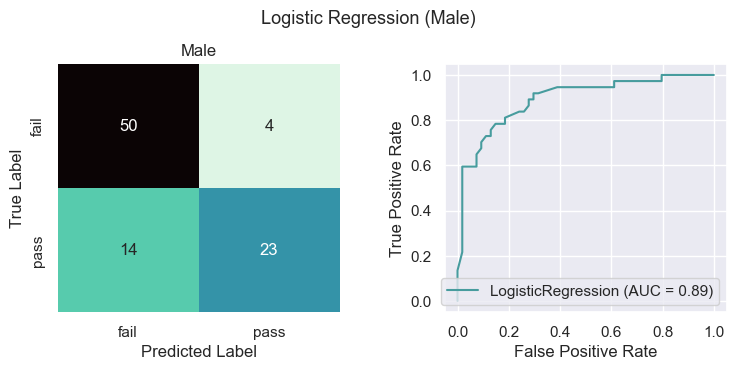

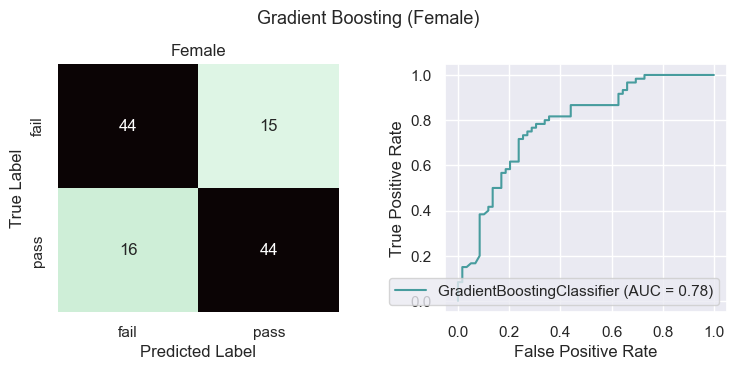

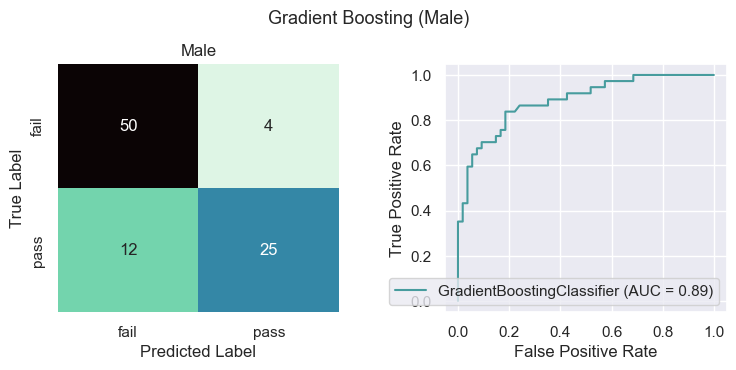

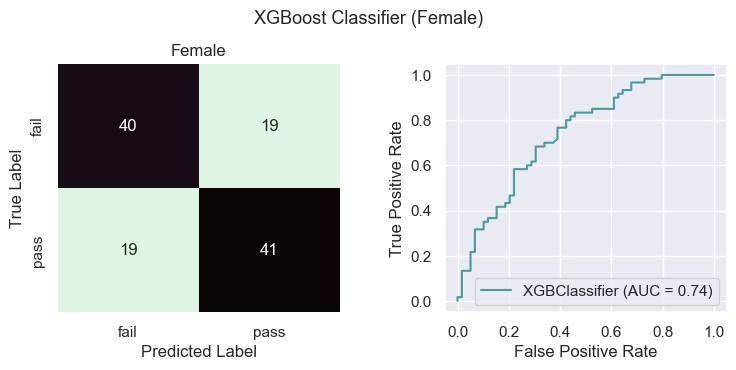

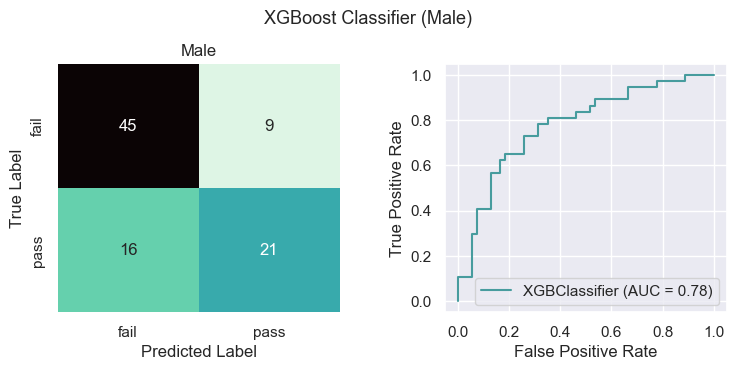

Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



Output(layout=Layout(border='2px solid black', width='580px'))

_________________________________________________________________________________



In [21]:
# Calculate AUC metrics after dimension reduction and display confusion matrix and ROC curve for each model.

display(Markdown("### Confusion Matrix And Area Under The Curve Performance After Dimension Reduction"))
print()
auc_scores = defaultdict(list)    
names = get_classifier_names()
for model, df_gender in importances.items():
    for gender, df in zip(['female', 'male'], df_gender):
        tuned_classifiers = get_tuned_classifiers(gender)
        for tuned_model, tuned_classifier in zip(names, tuned_classifiers):
            if tuned_model == model:
                auc_scores[gender].append(get_metrics(gender, df, drop_list, target, tuned_classifier, tuned_model))

female_tailored_auc, female_highest = display_auc_scores('Female', auc_scores['female'])
male_tailored_auc, male_highest = display_auc_scores('Male', auc_scores['male'])

print()
display(female_tailored_auc)
print('_'*81, end='\n\n')
display(male_tailored_auc)
print('_'*81, end='\n\n')

The ROC AUC score acceptability of the model predictions above are as follows (with scores rounded to the nearest percentage):
* Female Area Under The Curve - Gradient Boosting score of **78%** is in the upper **acceptable** range. 
* Male Area Under The Curve - Logistic Regression score of **89%** is in the higher **good** range.

Dimension reduction has a noticable positive effect on the female ROC AUC score and a very minor negative effect on the male score. Again, because the positive effect outweighs the negative effect, as well as moving the female score into the upper acceptable range, this is an acceptable trade-off.

In [22]:
# Display feature importances for most predictive model.

def display_important_features(gender, name, importance):
    out_plot = Output()
    with out_plot:
        fig, ax = plt.subplots()
        sns.barplot(data=importance, x='Feature Importances', y='Features', palette=cmap, ax=ax)

        ax.set_title(f"{name} ({gender})")
        ax.set_ylabel('')
        ax.set_xlabel('')

        plt.show()
    return out_plot

def print_important_features(gender, name, features):
    header = f"{name} ({gender})"
    hline = '_'*len(header)
    features_out = Output(layout={'border': '1px solid black', 'width': '230px'})
    with features_out:
        print(f"{header:^30}")
        print(f"{hline:^30}\n")
        display(features)
        print()
    return features_out

_, female_features_dict = tailor_dataset_by_importance(female, female_importances[female_highest[0]], feature_threshold)
_, male_features_dict = tailor_dataset_by_importance(male, male_importances[male_highest[0]], feature_threshold)

features2 = female_importances2[female_highest[0]]
feature_list = [f[0] for f in female_features_dict.values()]

df_female_features2 = features2.loc[features2['Features'].isin(feature_list)]
df_female_features2['Feature Importances'] = df_female_features2['Feature Importances'] * 100
df_female_features2.index = np.arange(1,len(df_female_features2)+1)
female_out2 = print_important_features('Female', female_highest[0], df_female_features2)

features2 = male_importances2[male_highest[0]]
feature_list = [f[0] for f in male_features_dict.values()]

df_male_features2 = features2.loc[features2['Features'].isin(feature_list)]
df_male_features2['Feature Importances'] = df_male_features2['Feature Importances'] * 100
df_male_features2.index = np.arange(1,len(df_male_features2)+1)
male_out2 = print_important_features('Male', male_highest[0], df_male_features2)

display(Markdown(f"### Feature Importances"))
print()
display(Markdown("##### According to the most predictive model for each gender, \
                 these are the factors that contribute most greatly to student academic performance prediction."))

female_out_display2 = display_important_features('Female', female_highest[0], df_female_features2)
male_out_display2 = display_important_features('Male', male_highest[0], df_male_features2)

print()
display(HBox([female_out_display2, male_out_display2], box_style='success'))
print()
display(HBox([female_out2, male_out2], box_style='success'))
print(f"With feature importance set at greater than absolute {feature_threshold*100:.2f}.\n")

### Feature Importances

##### According to the most predictive model for each gender,                  these are the factors that contribute most greatly to student academic performance prediction.

HBox(box_style='success', children=(Output(), Output()))

HBox(box_style='success', children=(Output(layout=Layout(border='1px solid black', width='230px')), Output(lay…

With feature importance set at greater than absolute 1.50.



### Further Exploration Opportunities

Additional experimentation can be easily performed simply by changing the initial variable setting for `feature_threshold` from '0.015' to a value
somewhat higher or lower (i.e., '0.01' or '0.02'). As well, the variable `passing_score` can be increased from '1' to '2' to increase the number of 
vulnerable students in the calculations. Both `feature_threshold` and `passing_score` can be found under `Global variables` within the initial 
settings at the top of this notebook.